<a href="https://colab.research.google.com/github/Remi-Branco/Public/blob/master/Machine_learning_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-20 05:15:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2020-03-20 05:15:40 (1.77 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [0]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

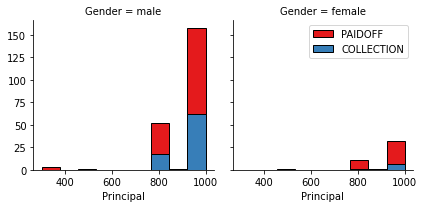

In [8]:
import seaborn as sns

#generate 10 bins using minimal & maximal values of Principal
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)

#data (DataFrame):  Tidy (“long-form”) dataframe where each column is a variable and each row is an observation.
#row, col, hue (strings): Variables that define subsets of the data, which will be drawn on separate facets in the grid. See the *_order parameters to control the order of levels of this variable.
#col_wrap (int, optional): “Wrap” the column variable at this width, so that the column facets span multiple rows. Incompatible with a row facet.

#generate multiplot using facetgrid
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2) 

g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

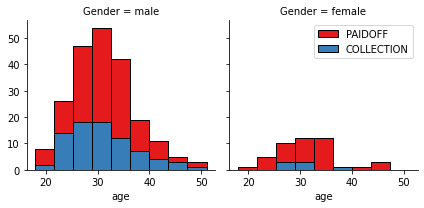

In [9]:
#generate 10 bins using minimal & maximal values of 'age'
bins = np.linspace(df.age.min(), df.age.max(), 10)

g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

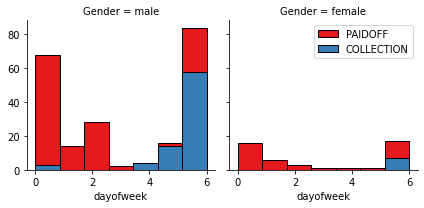

In [10]:
#add new column to df containing the day of the week using function dayofweek (The day of the week with Monday=0, Sunday=6)
df['dayofweek'] = df['effective_date'].dt.dayofweek
#generate bins
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8) #error here, need to generate 7 bins as there are 7 days in a week

g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
#create new column 'weekend' and use a lambda function to set given threshold..
#...where days before Wednesday are set to 1, the other days of the week are set to 0
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


Data only from September 2016 so no point in doing this for month or year

## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
#compute relative frequencies of ppl paying off their mortgage per gender
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True) #normalize : If True the object returned will contain the relative frequencies of the unique values

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
#create new dataframe Feature with 'Principal','terms','age','Gender','weekend' columns
Feature = df[['Principal','terms','age','Gender','weekend']]
#use function get_dummies to convert levels of eduction into dummy variables
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1) #each education level is converted into a column, 1 is added in column of corresponding education lvl, 0 otherwise
# remove the column 'Master or Above' as it does not have enough representants
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
#create a copy of Feature, resulting X is a dataframe
X = Feature
X[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
#we normalise the dataframe using StandardScaler function, X is a numpy array
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

#Split dataset into Train and Test

In [20]:
#split dataset using train_test_split function
from sklearn.model_selection import train_test_split
# the train_test_split function automatically shuffles and splits the dataset into 2 datasets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


#import functions for ALL models

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
##Create resssources for models
Ks = X_train.shape[0] #how many K (-1) we will try all ks as per number of rows

###    Jaccard index
#create an array of size Ks-1 initialised with zeros to store mean accuracy(i.e. Jaccard) and std
mean_acc_knn = np.zeros((Ks-1)) 
#std_acc = np.zeros((Ks-1))

###    F1-score
mean_F1_knn = np.zeros((Ks-1))
#std_F1 = np.zeros((Ks-1))
print('Ks =', Ks)

Ks = 276


In [0]:
##Fit knn models
for n in range(1,Ks):
    ###Train Model and Predict, fit the model with k = n neighbors
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train) 
    ###Predict y_hat-knn
    y_hat_knn=neigh.predict(X_test) #use model to predict y_hat using test dataset

    ###Measure model accuracy(Jaccard), F1 score and Logloss
    #Jaccard, store average results in list
    mean_acc_knn[n-1] = metrics.accuracy_score(y_test, y_hat_knn) 
    #F1 score, store average results in list
    mean_F1_knn[n-1] = metrics.f1_score(y_test, y_hat_knn, average='weighted')
    #print (mean_F1[n-1])


In [24]:
##Evaluate knn-models

print( "The best accuracy was with", mean_acc_knn.max(), "with k=", mean_acc_knn.argmax()+1)
print( "The best F1 was with", mean_F1_knn.max(), "with k=", mean_F1_knn.argmax()+1)


The best accuracy was with 0.7857142857142857 with k= 7
The best F1 was with 0.7766540244416351 with k= 7


In [0]:
#retrain model on entire dataset with k = 7 and using whole dataset
neigh_opt = KNeighborsClassifier(n_neighbors = 7).fit(X,y) 


# Decision Tree

In [26]:
###Create Model and Predict, fit the model with k = max_depth
loanTree_Model = DecisionTreeClassifier(criterion="entropy", max_depth = 4) 
###Fit the tree
loanTree_Model.fit(X_train,y_train)

###Predict y_hat
y_hat_tree = loanTree_Model.predict(X_test)

###Measure model accuracy(Jaccard), F1 score and Logloss
#Jaccard, store average results in list
mean_acc_tree = metrics.accuracy_score(y_test, y_hat_tree)
#F1 score, store average results in list
mean_F1_tree = metrics.f1_score(y_test, y_hat_tree, average='weighted')

print("  Acc:" ,mean_acc_tree,"  F1:",mean_F1_tree )

  Acc: 0.6142857142857143   F1: 0.6445993031358885


In [0]:
#retrain model on entire dataset with best parameters based on Jacc
###Create Model and Predict, fit the model with k = max_depth
loanTree_Model_opt = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X,y) 

# Support Vector Machine

In [0]:
##Create ressources for trying different kernels and pick the best one
kernels = ['linear','rbf','poly','sigmoid']
n_kernels = len(kernels) #how many kernels we'll try

###    Jaccard index
#create an array of size n_kernels-1 initialised with zeros to store mean accuracy(i.e. Jaccard) and std
acc_SVM = np.zeros((n_kernels)) 
###    F1-score
F1_SVM = np.zeros((n_kernels))

In [29]:
##Fit SVM models changing kernel each time
for n in range(0,n_kernels):
    print('\n',n,kernels[n])
    ###Create Model and Predict, fit the model with k = max_depth
    clf = svm.SVC(kernel=kernels[n],probability=True) ##############check what probability does
    #fit model using train datasets
    clf.fit(X_train, y_train)

    ###Predict y_hat
    y_hat_SVM = clf.predict(X_test)

    ###Measure model accuracy(Jaccard), F1 score and Logloss
    #Jaccard, store average results in list
    acc_SVM[n] = metrics.accuracy_score(y_test, y_hat_SVM)

    #F1 score, store average results in list
    F1_SVM[n] = metrics.f1_score(y_test, y_hat_SVM, average='weighted')

    print("n:",n, "  Acc:" ,acc_SVM[n],"  F1:",F1_SVM[n] )


 0 linear
n: 0   Acc: 0.7857142857142857   F1: 0.6914285714285714

 1 rbf
n: 1   Acc: 0.7428571428571429   F1: 0.7275882012724117

 2 poly
n: 2   Acc: 0.7714285714285715   F1: 0.7064793130366899

 3 sigmoid
n: 3   Acc: 0.7428571428571429   F1: 0.6892857142857144


In [30]:
##Evaluate SVM models
print( "The best accuracy was with", acc_SVM.max(), "with ", kernels[acc_SVM.argmax()],' kernel')
print( "The best F1 was with", F1_SVM.max(), "with ", kernels[F1_SVM.argmax()],' kernel')

The best accuracy was with 0.7857142857142857 with  linear  kernel
The best F1 was with 0.7275882012724117 with  rbf  kernel


In [0]:
#retrain model on entire dataset with kernel rbf
clf_optimal = svm.SVC(kernel='rbf',probability=True).fit(X, y) 

# Logistic Regression

In [0]:
solvers = ['liblinear','newton-cg','lbfgs', 'sag', 'saga']

###    Jaccard index
#create an array of size n_kernels-1 initialised with zeros to store mean accuracy(i.e. Jaccard) and std
acc_LR = np.zeros(len(solvers)) 
###    F1-score
F1_LR = np.zeros(len(solvers))
###    LogLoss
logloss_LR = np.zeros(len(solvers))

In [33]:
for n in range(0,len(solvers)):
    print('\n solver:', solvers[n] )
    LRmodel = LogisticRegression(C=0.01, solver=solvers[n]).fit(X_train,y_train) # C parameter indicates inverse of regularisation strength, must be a positive float
    y_hat_LR = LRmodel.predict(X_test)
    #use the method predict_proba from LR object (model) to calculate the probabilities for each
    y_hat_prob_LR = LRmodel.predict_proba(X_test)


    ###Measure model accuracy(Jaccard), F1 score and Logloss
    #Jaccard, store average results in list
    acc_LR[n] = metrics.accuracy_score(y_test, y_hat_LR)

    #F1 score, store average results in list
    F1_LR[n] = metrics.f1_score(y_test, y_hat_LR, average='weighted')

    #logloss
    ###compute 
    y_hat_LR_prob = LRmodel.predict_proba(X_test)
    logloss_LR[n] = log_loss(y_test, y_hat_LR_prob)
    print("n:",n, "  Acc:" ,acc_LR[n],"  F1:",F1_LR[n], "  logloss:",logloss_LR[n]  )


 solver: liblinear
n: 0   Acc: 0.6857142857142857   F1: 0.6670522459996144   logloss: 0.5772287609479654

 solver: newton-cg
n: 1   Acc: 0.7857142857142857   F1: 0.6914285714285714   logloss: 0.492017801467927

 solver: lbfgs
n: 2   Acc: 0.7857142857142857   F1: 0.6914285714285714   logloss: 0.4920179847937498

 solver: sag
n: 3   Acc: 0.7857142857142857   F1: 0.6914285714285714   logloss: 0.4920267712349135

 solver: saga
n: 4   Acc: 0.7857142857142857   F1: 0.6914285714285714   logloss: 0.49201846188062753


In [34]:
##Evaluate LR models
print( "The best accuracy was with", acc_LR.max(), "with ", solvers[acc_LR.argmax()],' solver')
print( "The best F1 was with", F1_LR.max(), "with ", solvers[F1_LR.argmax()],' solver')
print( "The best logloss was with", logloss_LR.min(), "with ", solvers[logloss_LR.argmin()],' solver')

The best accuracy was with 0.7857142857142857 with  newton-cg  solver
The best F1 was with 0.6914285714285714 with  newton-cg  solver
The best logloss was with 0.492017801467927 with  newton-cg  solver


In [0]:
#retrain model on entire dataset with Newton solver (best one based on above cell)
LRmodel_opt = LogisticRegression(C=0.01, solver=solvers[acc_LR.argmax()]).fit(X,y)


# Model Evaluation using Test set

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-20 05:15:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-03-20 05:15:46 (744 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [38]:
test_df = pd.read_csv('loan_test.csv')
print('Dataset shape: ', test_df.shape)
#preprocess all data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
#add new column to df containing the day of the week using function dayofweek (The day of the week with Monday=0, Sunday=6)
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#create new column 'weekend' and use a lambda function to set given threshold..
#...where days before Wednesday are set to 1, the other days of the week are set to 0
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#compute relative frequencies of ppl paying off their mortgage per gender
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True) #normalize : If True the object returned will contain the relative frequencies of the unique values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#create new dataframe Feature with 'Principal','terms','age','Gender','weekend' columns
Feature = test_df[['Principal','terms','age','Gender','weekend']]
#use function get_dummies to convert levels of eduction into dummy variables
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1) #each education level is converted into a column, 1 is added in column of corresponding education lvl, 0 otherwise
# remove the column 'Master or Above' as it does not have enough representants
Feature.drop(['Master or Above'], axis = 1,inplace=True)
#create a copy of Feature, resulting X is a dataframe
X_testset = Feature
y_testset = test_df['loan_status'].values

#we normalise the dataframe using StandardScaler function, X is a numpy array
X_testset= preprocessing.StandardScaler().fit(X_testset).transform(X_testset)

Dataset shape:  (54, 10)


In [39]:
####Predict y_hat values
### KNNs
y_hat_knn_testset = neigh_opt.predict(X_testset) #use model to predict y_hat using test dataset
KNN_Jacc = metrics.accuracy_score(y_testset, y_hat_knn_testset)
print("KNN Jaccard:",KNN_Jacc )
KNN_F1 = metrics.f1_score(y_testset, y_hat_knn_testset ,average = 'weighted')
print("KNN F1:",KNN_F1 )


KNN Jaccard: 0.7222222222222222
KNN F1: 0.7001989201477693


In [40]:
###DecisionTree
y_hat_tree_testset = loanTree_Model_opt.predict(X_testset)
DT_Jacc = metrics.accuracy_score(y_testset, y_hat_tree_testset)
print("DT Jaccard:",DT_Jacc )
DT_F1 = metrics.f1_score(y_testset, y_hat_tree_testset , average='weighted')
print("DT F1:",DT_F1 )

DT Jaccard: 0.7777777777777778
DT F1: 0.7283950617283951


In [41]:
###SVM
y_hat_SVM_testset = clf_optimal.predict(X_testset)
SVM_Jacc = metrics.accuracy_score(y_testset, y_hat_SVM_testset )
print("SVM Jaccard:",SVM_Jacc )
SVM_F1 = metrics.f1_score(y_testset, y_hat_SVM_testset , average='weighted' )
print("SVM F1:",SVM_F1 )

SVM Jaccard: 0.7222222222222222
SVM F1: 0.6212664277180406


In [42]:
###LogisticRegression
y_hat_LR_testset  = LRmodel_opt.predict(X_testset)
LR_Jacc = metrics.accuracy_score(y_testset, y_hat_LR_testset )
print("LR Jaccard:",LR_Jacc )
LR_F1 = metrics.f1_score(y_testset, y_hat_LR_testset , average='weighted' )
print("LR F1:",LR_F1 )
#-logloss metric for LR only
y_hat_proba_LR_testset = LRmodel_opt.predict_proba(X_testset)
LR_logloss = log_loss(y_testset , y_hat_proba_LR_testset)
print("LR LogLoss:",LR_logloss )

LR Jaccard: 0.7407407407407407
LR F1: 0.6304176516942475
LR LogLoss: 0.5153605391282531


In [43]:
# list of strings 
lst = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'] 

KNNlist          = [ 'KNN',KNN_Jacc , KNN_F1,'Nan']
DecisionTreelist = ['Decision Tree',DT_Jacc , DT_F1, 'Nan']
SVMlist          = ['SVM',SVM_Jacc ,SVM_F1 , 'Nan']
loglosslist = ['Logistic Regression',LR_Jacc , LR_F1 ,LR_logloss]

data = [KNNlist,DecisionTreelist,SVMlist,loglosslist]
df_results = pd.DataFrame(data, columns =['Algorithm','Jaccard','F1-score','LogLoss']) 
df_results

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.722222,0.700199,Nan
1,Decision Tree,0.777778,0.728395,Nan
2,SVM,0.722222,0.621266,Nan
3,Logistic Regression,0.740741,0.630418,0.515361


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72       | 0.70        | NA      |
| Decision Tree      | 0.78       | 0.73        | NA      |
| SVM                | 0.72       | 0.62        | NA      |
| LogisticRegression | 0.74       | 0.63        | 0.52       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>